# Neural Networks
*by [GRAM](https://gra.m-gan.sl), Head of Data Science, Expero Inc*

There's no magic here. 

We've all heard a proselytizing hyperbolist make the an-AI-is-going-to-steal-my-job speech. If you subscribe, look at the following code cell. It demonstrates all the tenets of deep learning. You'll find a simple system composed exclusively of multiply and add operations. That's all that happens inside a neural network. Multiply and add.

A neural network is nothing but a nonlinear system of equations like $\mathbf{y} = \sigma(\mathbf{W}\mathbf{X} + \mathbf{b})$. Seriously. 

> Comment: Not sure if this is too bold? You also need a mechanism for adjusting the weights $\mathbf{W}$ to minimize the difference between the network's output and the expected output, right? That is, backprop.

In [58]:
import numpy as np

% matplotlib inline
import matplotlib.pyplot as plt

from tqdm import tnrange

> Add: The nonlinearity is introduced by the sigmoid function:
>
> $$ \sigma(z) = \frac{1}{1 + \operatorname{e}^z} $$
>
> We provide two versions of it, one for the forward pass, and the derivative of the expression for the backpropagation step.

In [59]:
def sigma(z, forward=True):
    if forward:
        return 1 / (1 + np.exp(-z))
    else:
        return z * (1 - z)

> Suggestion: Keep the Python as close as possible to the mathematical notation.

> Suggestion: Show the math before the code.

In [60]:
def forward(X, W1, b1, W2, b2):
    z1 = W1 @ X + b1
    a1 = sigma(z1)
    z2 = W2 @ a1 + b2
    return z2, a1

Let's implement two-deep nested set of nonlinear equations. It looks like this:

\begin{equation*}
\hat{\mathbf{y}} = \sigma(\mathbf{X} * \mathbf{W}_1 + \mathbf{b}_1) * \mathbf{W}_2 + \mathbf{b}_2,
\end{equation*}

where $\mathbf{X}$ is the input data, $\mathbf{W}_1, \mathbf{W}_2, \mathbf{b}_1, \mathbf{b}_2$ are weight and bias vectors for layers 1 and 2 respectively, and $\sigma()$ is a nonlinear function (the "sigmoid" function in the rest of this notebook).

> Remark: I'm used to thinking about X and W as matrices, and you call them matrices... I've tried to stick to matrices everywhere.

For those uninterested, check out this picture of the above neural network with parameters we'll define in subsequent code blocks:

![image](nn_arch.png)

Here we see a simple neural network which takes one number as input (the green neuron) and outputs one number (the red neuron). In the middle (the orange neurons) we have a so-called "hidden layer," which in this case is a 300 number array. Moving information from input layer, to hidden layer, to output layer is as simple as matrix multiplying and adding numbers. In the middle we apply a sigmoid function to each of the numbers.

**We care about this because we can "teach" this simple system to model a mapping between one set of numbers and another set.** For example, we can train this system to output a one when we input a one, a two when we input a two, and an N when we input an N. This is equivalent to building a linear model, but--more interestingly--we could teach it to output a nonlinear model: one maps to one, two maps to four, and N maps to $N^2$. In the following code, we'll train this model to learn a sine function.

How does it "learn?" By adjusting the "w"s and "b"s you see in the equations above. The mechanics here are important, so if your proclivities are mathematical in nature pick through the following code block.

The *TL;DR* is that we show the system a bunch of corresponding input/output pairs we want it to learn, and we show it these pairs thousands of times. Every time we do so, we subtract a little bit off of each of the "w"s and "b"s in the direction that makes the outputs of the network more similar to the known output we're trying to teach it.

Algorithm:

- initialize matrices for weight gradients

- calculate error signal for output layer
- update weight gradient for output layer
- update weights for output layer

- bias gradient for output layer
- update biases for output layer
    
- calculate error signal for hidden layer
- update gradient for hidden layer
- update weights for hidden layer

- bias gradient for hidden layer
- update biases for hidden layer

In [61]:
def backward(xi, yi,
             a1, z2,
             params,
             learning_rate):

    delta_output = z2 - yi
    grad_W2 = delta_output * a1
    params['W2'] -= learning_rate * grad_W2

    grad_b2 = delta_output
    params['b2'] -= learning_rate * grad_b2

    grad = sigma(a1, forward=False)
    delta_hidden = grad * delta_output * params['W2']
    grad_W1 = delta_hidden.reshape((-1, 1)) @ xi.reshape((1, -1))
    params['W1'] -= learning_rate * grad_W1
    
    grad_b1 = delta_hidden
    params['b1'] -= learning_rate * grad_b1
    
    return params

The previous code block is called optimization by the backpropagation of gradients. It is the critical piece of thinking which enabled the deep learning revolution. It is the reason Google can translate from Hindi to English. It is the reason the exchange of securities on public markets is no longer performed primarily by humans. It is the reason we can predict the failure of drilling equipment days in advance of failure.

> Remark: Citation needed for that last statement I think, as it's a pretty bold claim that will be news to most people. If there is no citation, then I think you need to phrase it more like it's promising ongoing research.

To demonstrate this backpropagation workflow, and thus that our system can learn, let's try to get the above neural network to learn the Zoerppritz equation. We'll compute the exact Zoeppritz solution for our logs at 30 degrees of offset:

In [112]:
# The number of data samples we'll use.
n = 200

In [113]:
from welly import Well
from bruges.reflection import zoeppritz_rpp
import bruges

w = Well.from_las("R-39.las")

VP = 1e6 / w.data['DT4P']
VS = 1e6 / w.data['DT4S']
RHO = w.data['RHOB']

# There is some dodgy data in the VS log
VS[VS<0] = np.mean(VS)

vp = VP[::5][:n+1]
vs = VS[::5][:n+1]
rho = RHO[::5][:n+1]

vp1 = vp[:-1]
vs1 = vs[:-1]
rho1 = rho[:-1]

vp2 = vp[1:]
vs2 = vs[1:]
rho2 = rho[1:]

In [114]:
theta = 30
X_ = np.vstack([vp1, vs1, rho1, vp2, vs2, rho2]).T
y_ = zoeppritz_rpp(vp1, vs1, rho1, vp2, vs2, rho2, theta)

In [115]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X_)
y = y_.real

In [116]:
X.shape, y.shape

((200, 6), (200,))

<Container object of 3 artists>

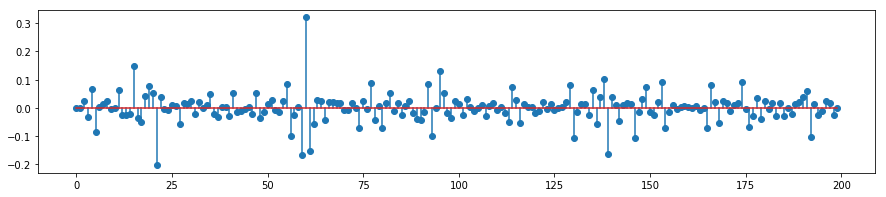

In [117]:
plt.figure(figsize=(15, 3))
plt.stem(y)

## Train the network

Now we can initialize the weights and biases for our network:

In [118]:
from numpy.random import uniform, randn

In [119]:
def initialize_params(units):
    np.random.seed(42)
    params = {
        "W1": 0.1 * randn(units, X.shape[-1]),
        "b1": np.zeros(shape=units),

        "W2": 0.1 * randn(units),
        "b2": np.zeros(shape=1)
    }
    return params

In [137]:
units = 1

params = initialize_params(units=units)

In [138]:
pre_train = []
for xi in X:
    y_pred, _ = forward(xi, **params)
    pre_train.append(np.asscalar(y_pred))

One at a time, we expose the network to the input/output pairs (these are labeled x and y respectively in the code). According to our diagram above, the input goes into the green slot and we adjust the orange neurons to make the red slot output from the network a tiny bit closer (0.1%) to the true output of the sine function.

We do this 20,000 times. Every time we do, we output the "mean squared error" (half of the squared distance) between the network's prediction and the groundtruth output from the sine function. After these twenty thousand iterations, or "epochs," we draw out a plot which shows that loss at each step. If the network is learning anything, we expect the loss to decrease, as the predictions are getting closer to the groundtruth.

In [139]:
def loss(y, yi_pred):
    return 0.5 * np.asscalar(np.square(y - yi_pred))

In [140]:
num_epochs = 2000
learning_rate = 0.001
loss_history = []

params = initialize_params(units=units)

for i in tnrange(num_epochs):
    for xi, yi in zip(X, y):

        z2, a1 = forward(xi, **params)

        params = backward(xi, yi,
                          a1, z2,
                          params,
                          learning_rate)

    loss_history.append(loss(z2, yi))

A Jupyter Widget

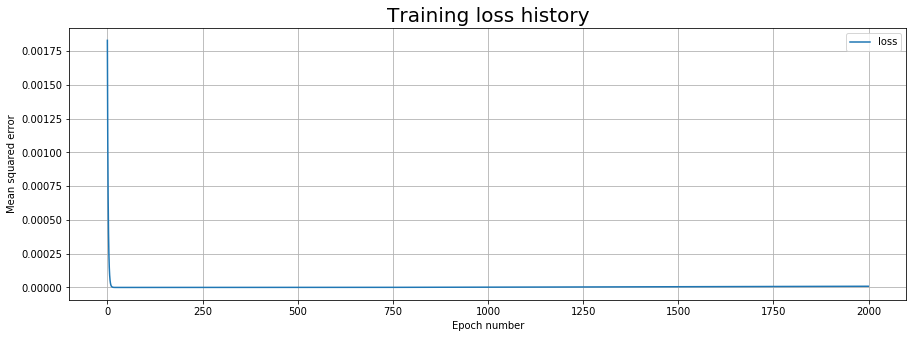

In [141]:
plt.figure(figsize=(15,5))

plt.plot(loss_history, label='loss')

plt.title('Training loss history', fontsize=20)
plt.xlabel('Epoch number')
plt.ylabel('Mean squared error')
plt.grid()
plt.legend()
plt.show()

The loss decreased dramatically over the course of twenty thousand epochs, so presumably the network has learned something. To test this theory, we'll plot a bunch of network outputs before and after training.

Note that in the next code block that we're actually feeding the network inputs which it hasn't been trained on. In particular, some of these inputs are outside the "span of the input domain," which simply means we're feeding in values outside the [0, 2$\pi$] values we trained on. This is an important concept in statistical modeling known as the "generalizability" of a model.

In [142]:
post_train = []
for xi in X:
    y_pred, _ = forward(xi, **params)
    post_train.append(np.asscalar(y_pred))

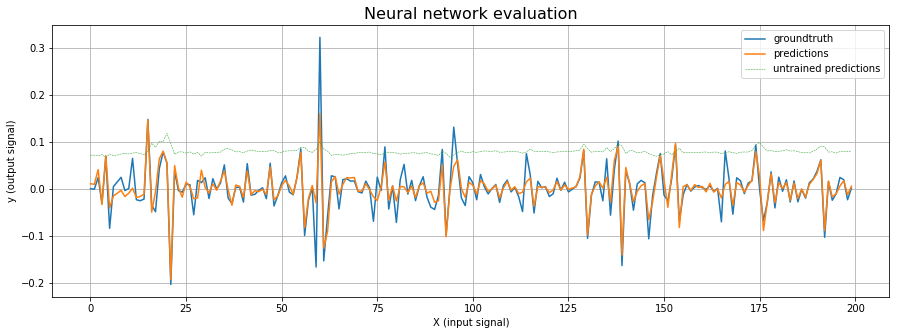

In [143]:
#
plt.figure(figsize=(15,5))
plt.title('Neural network evaluation', fontsize=16)
plt.xlabel('X (input signal)')
plt.ylabel('y (output signal)')

plt.plot(y, label='groundtruth')
plt.plot(post_train, label='predictions')
plt.plot(pre_train, '--', label='untrained predictions', lw=0.5)

#plt.scatter(blind, blind_preds, color='red', label='interesting predictions')

plt.grid()
plt.legend()
plt.show()
#plt.savefig('output.png', dpi=300)

## Blind test

New part of logs:

In [144]:
n = 100

vp = VP[::5][-n-1:]
vs = VS[::5][-n-1:]
rho = RHO[::5][-n-1:]

vp1 = vp[:-1]
vs1 = vs[:-1]
rho1 = rho[:-1]

vp2 = vp[1:]
vs2 = vs[1:]
rho2 = rho[1:]

In [145]:
theta = 10

y_blind = zoeppritz_rpp(vp1, vs1, rho1, vp2, vs2, rho2, theta1=theta)
X_blind_ = np.vstack([vp1, vs1, rho1, vp2, vs2, rho2]).T

X_blind = scaler.transform(X_blind_)

In [146]:
blind_train = []
for xi in X_blind:
    y_pred, _ = forward(xi, **params)
    blind_train.append(np.asscalar(y_pred))

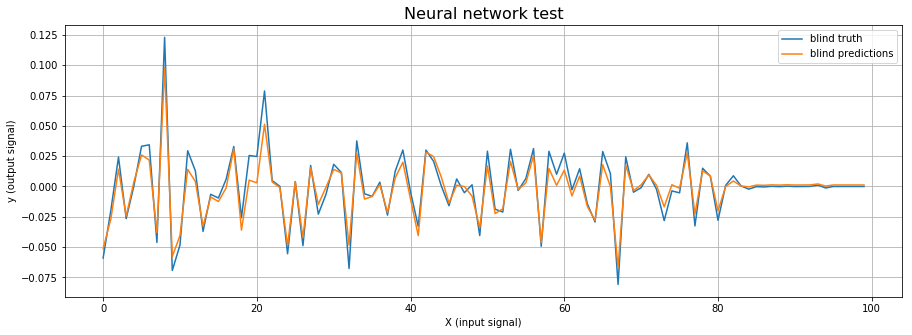

In [147]:
plt.figure(figsize=(15,5))

plt.title('Neural network test', fontsize=16)
plt.xlabel('X (input signal)')
plt.ylabel('y (output signal)')

plt.plot(y_blind.real, label='blind truth')
plt.plot(blind_train, label='blind predictions')

plt.grid()
plt.legend()
plt.show()

The blue line is the true sine function we coded. The orange line is the output from the network before training. The green line is the output from the network after training. The red dots are points of interest in the output from the trained model. So, indeed, our neural network has learned to approximate a sine function!

If you're interested in understanding this work more deeply, here are two questions to answer:
1. Why doesn't the blue line match the green line perfectly, especially at the extrema of the original function?
2. Is it interesting that the red dots turn around and head back in the increasing direction on the left side of the plot?

That's it. That's all of deep learning. Multiply, add, apply nonlinearity. No magic. No "intelligence." Just simple arithmetic. Told you.

### Challenges

- Vary theta in the input data and try to learn that feature too (see other notebook).
- Try a different activation function, e.g. tanh or ReLu.
- Add another hidden layer.
- Add regularization.
- Train on batches of input data, only updating the weights after every 10 or 100 training instances.
- Implement this network in PyTorch or Keras.